In [1]:
%pip install -q torchtext
%pip install -q PyMuPDF
%pip install -q torch_snippets

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from torch_snippets import Report #showcase precision, recall, f1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
#Connecting to google drive to get the data
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd gdrive/MyDrive/'Text Mining Project Folder'/'Train and Test Data'/'Reddit Final Train+Test'

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/10i18JZwcNchw6ljHdhoTHU3vfRb5YTBD/Text Mining Project/Train and Test Data/Reddit Final Train+Test


In [3]:
train = pd.read_csv('train.csv')
val = pd.read_csv('val.csv')
test = pd.read_csv('reddit_golden_test.csv')

print(train.shape)
print(train.groupby('label').size())

print(val.shape)
print(val.groupby('label').size())

print(test.shape)
print(test.groupby('label').size())

(35160, 2)
label
0    11720
1    11720
2    11720
dtype: int64
(8790, 2)
label
0    2930
1    2930
2    2930
dtype: int64
(600, 3)
label
0    200
1    200
2    200
dtype: int64


In [4]:
train_X = train['cleanedreddit']
val_X = val['cleanedreddit']
test_X = test['cleanedreddit']

train_Y = train['label']
val_Y = val['label']
test_Y = test['label']

In [5]:
unk_idx = 1
pad_idx = 0
class VocabEncoder():
    def __init__(self, vocab):
        self.encoder = {word : index for index, word in enumerate(vocab)}
    
    def __call__(self, tokens):
        return [self.encoder[token] if self.encoder.get(token) else unk_idx for token in tokens]

In [6]:
%cd ../../'Embeddings'/'Fasttext'
vocab = np.load("vocab_npa.npy", allow_pickle=True)
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')        
vocab_encoder = VocabEncoder(vocab)
embedding_weights = np.load("embs_npa.npy", allow_pickle=True)

/content/gdrive/.shortcut-targets-by-id/10i18JZwcNchw6ljHdhoTHU3vfRb5YTBD/Text Mining Project/Embeddings/Fasttext


In [7]:
#collate fn
def vectorize_batch(batch):
    text,labels = zip(*batch)

    text = [torch.tensor(vocab_encoder(tokenizer(x)), dtype=torch.long) for x in text] 

    text = pad_sequence(text, padding_value=pad_idx) 

    #text = text.T

    text,labels = torch.tensor(text), torch.tensor(labels)

    return text, labels

In [8]:
batch_size = 16

train_dataset = list(zip(train_X, train_Y))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=vectorize_batch)
num_train_batches = len(train_dataloader)

val_dataset = list(zip(val_X, val_Y))
test_dataset = list(zip(test_X, test_Y))
val_X, val_Y = vectorize_batch(val_dataset)
test_X, test_Y = vectorize_batch(test_dataset)


#move to GPU
val_X = val_X.to(device)
val_Y = val_Y.to(device)
test_X = test_X.to(device)
test_Y = test_Y.to(device)

<ipython-input-7-cd096e29a6b6>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text,labels = torch.tensor(text), torch.tensor(labels)


In [9]:
max_len_train = max([len(x) for x,y in train_dataloader])
max_len_val = max([len(x) for x,y in val_dataset])
max_len = max(max_len_train, max_len_val)

<ipython-input-7-cd096e29a6b6>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text,labels = torch.tensor(text), torch.tensor(labels)


In [28]:
class MLP(nn.Module):
    def __init__(self, output_dim, max_len):
        super().__init__()
        
        self.fc1 = nn.Linear(max_len, 128)
        self.fc2 = nn.Linear(128, output_dim)
        
    def forward(self, x):
        out = F.pad(x, (0,0,0,max_len-x.shape[0]), value=pad_idx)
        out = out.float()
        out = out.T
        out = F.relu(self.fc1(out))
        out = self.fc2(out)

        return out

In [29]:
#class to stop the training if the validation loss does not improve for x epochs
patience = 15 #number of epochs to wait before early stopping
class EarlyStopper:
    def __init__(self, patience=patience):
        self.patience = patience
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True

In [30]:
#function to train single batch in a single epoch
def train_batch(batch, model, optimizer, criterion):

    data, label = batch
    data, label = data.to(device), label.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, label)
    accuracy = (output.argmax(1) == label).float().mean()
    loss.backward()
    optimizer.step()

    return loss.item(), accuracy

#function to validate model on validation set
def validate_batch(val_X,val_Y, model, criterion):

    with torch.no_grad():
        output = model(val_X)
        loss = criterion(output, val_Y)
        accuracy = (output.argmax(1) == val_Y).float().mean()

    return loss.item(), accuracy

In [31]:
def train(epochs, model, optimizer, criterion, log):
    early_stopper = EarlyStopper()

    for epoch in range(epochs):

        model.train()
        for batch_idx, batch in enumerate(train_dataloader):

            loss, accuracy = train_batch(batch, model, optimizer, criterion)

            #pos is the position of the batch in the epoch -> used for logging and shows the progress of the epoch
            pos = (epoch + (batch_idx + 1) / num_train_batches)
            log.record(pos, trn_loss=loss, trn_acc=accuracy, end='\r')


        model.eval()
        loss, accuracy = validate_batch(val_X,val_Y, model, criterion)
        log.record((epoch + 1), val_loss=loss, val_acc=accuracy, end='\r')

        #check if the model should be early stopped
        if early_stopper.early_stop(loss):
            break
    
    #print the current state of the log
    print("\ntrain_acc:", np.mean([v for pos, v in log.trn_acc]), "|val_acc:", np.mean([v for pos, v in log.val_acc]))

In [32]:
#hyperparameters
vocab_size = len(vocab)
output_dim = 3
lr = 1e-3
epochs = 100

model = MLP(output_dim, max_len)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
log = Report(epochs)

In [33]:
train(epochs, model, optimizer, criterion, log)

<ipython-input-7-cd096e29a6b6>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text,labels = torch.tensor(text), torch.tensor(labels)


EPOCH: 28.000  val_loss: 1.025  val_acc: 0.513  (308.21s - 792.54s remaining)
train_acc: 0.4890586409723125 |val_acc: 0.5014952069946698


100%|██████████| 201/201 [00:02<00:00, 92.25it/s] 


[04/13/23 10:04:33] INFO     metric val_loss was not fully recorded. Plotting final ]8;id=370251;file:///usr/local/lib/python3.9/dist-packages/torch_snippets/torch_loader.py\torch_loader.py]8;;\:]8;id=413108;file:///usr/local/lib/python3.9/dist-packages/torch_snippets/torch_loader.py#plot_epochs:235\plot_epochs:235]8;;\
                             epochs using last recorded value                                                      

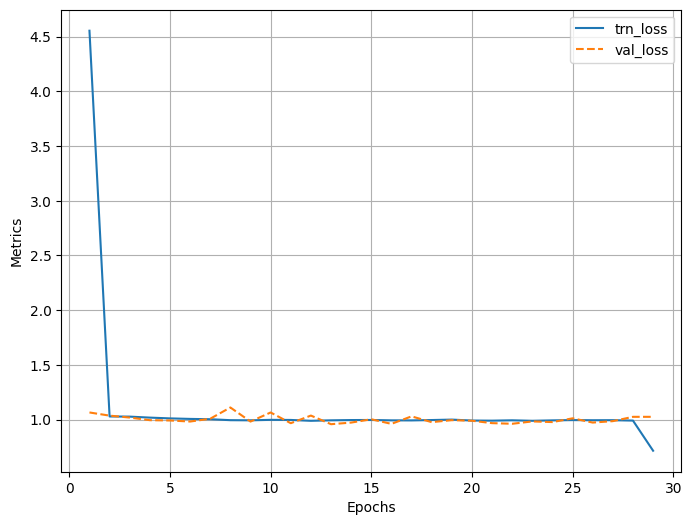

In [34]:
log.plot_epochs('trn_loss,val_loss'.split(','))

In [35]:
#testing the model
def test(model, data, dataloader=False):

    model.eval()
    all_outputs = []

    if dataloader:
        with torch.no_grad():
            for batch_idx, batch in enumerate(data):
                data, label = batch
                data, label = data.to(device), label.to(device)
                output = model(data)
                all_outputs.append(output.argmax(1))
    else:
        with torch.no_grad():
            data = data.to(device)
            output = model(data)
            all_outputs.append(output.argmax(1))

    all_outputs = np.array([item.item() for sublist in all_outputs for item in sublist])

    return all_outputs

<ipython-input-7-cd096e29a6b6>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text,labels = torch.tensor(text), torch.tensor(labels)


F1 score on train = 0.5156996587030717
Classification report on train
              precision    recall  f1-score   support

           0       0.45      0.28      0.35     11720
           1       0.54      0.42      0.47     11720
           2       0.53      0.85      0.65     11720

    accuracy                           0.52     35160
   macro avg       0.51      0.52      0.49     35160
weighted avg       0.51      0.52      0.49     35160

F1 score on validation = 0.5130830489192264
Classification report on validation
              precision    recall  f1-score   support

           0       0.45      0.28      0.35      2930
           1       0.55      0.41      0.47      2930
           2       0.52      0.84      0.64      2930

    accuracy                           0.51      8790
   macro avg       0.51      0.51      0.49      8790
weighted avg       0.51      0.51      0.49      8790

0 Anxiety 1 Depression 2 Neutral


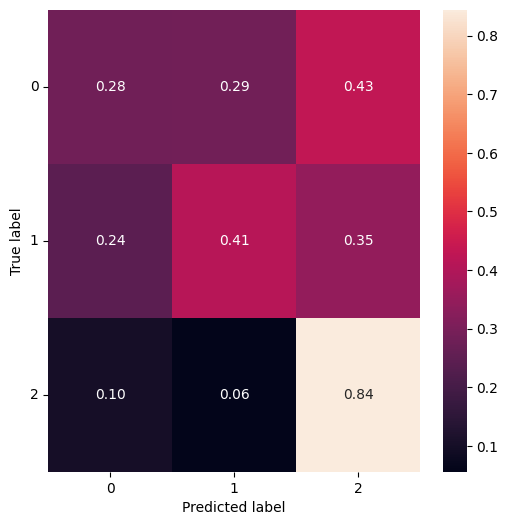

In [36]:
#Evaluate model on train set
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=vectorize_batch)
y_pred = test(model, train_dataloader, True)
train_X, train_Y = vectorize_batch(train_dataset)
y_true = train_Y.cpu().numpy()
score = f1_score(y_true, y_pred, average='micro')
print('F1 score on train = {}'.format(score))
clf_report = classification_report(y_true, y_pred)
print('Classification report on train')
print(clf_report)

#Evaluate model on validation set
y_pred = test(model, val_X)
y_true = val_Y.cpu().numpy()
score = f1_score(y_true, y_pred, average='micro')
print('F1 score on validation = {}'.format(score))
clf_report = classification_report(y_true, y_pred)
print('Classification report on validation')
print(clf_report)

#confusion matrix on validation set
print(0,"Anxiety", 1,"Depression", 2,"Neutral")
cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.ylabel('True label')
plt.yticks(rotation=0)
plt.xlabel('Predicted label')
plt.show()

F1 score on test = 0.35
Classification report on test
              precision    recall  f1-score   support

           0       0.35      0.23      0.27       200
           1       0.33      0.46      0.38       200
           2       0.38      0.37      0.37       200

    accuracy                           0.35       600
   macro avg       0.35      0.35      0.34       600
weighted avg       0.35      0.35      0.34       600

0 Anxiety 1 Depression 2 Neutral


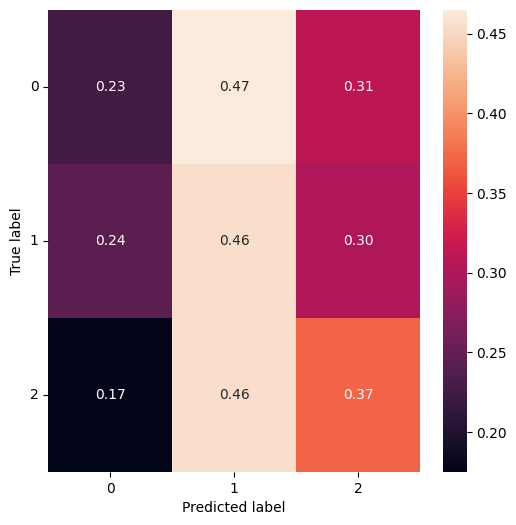

In [37]:
#Evaluate model on test set
y_pred = test(model, test_X)
y_true = test_Y.cpu().numpy()
score = f1_score(y_true, y_pred, average='micro')
print('F1 score on test = {}'.format(score))
clf_report = classification_report(y_true, y_pred)
print('Classification report on test')
print(clf_report)

#confusion matrix on validation set
print(0,"Anxiety", 1,"Depression", 2,"Neutral")
cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.ylabel('True label')
plt.yticks(rotation=0)
plt.xlabel('Predicted label')
plt.show()

/content/gdrive/.shortcut-targets-by-id/10i18JZwcNchw6ljHdhoTHU3vfRb5YTBD/Text Mining Project/Train and Test Data/Twitter Test


<ipython-input-7-cd096e29a6b6>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text,labels = torch.tensor(text), torch.tensor(labels)


F1 score on test = 0.4933333333333334
Classification report on test
              precision    recall  f1-score   support

           0       0.38      0.33      0.35       200
           1       0.48      0.59      0.53       200
           2       0.62      0.56      0.59       200

    accuracy                           0.49       600
   macro avg       0.49      0.49      0.49       600
weighted avg       0.49      0.49      0.49       600

0 Anxiety 1 Depression 2 Neutral


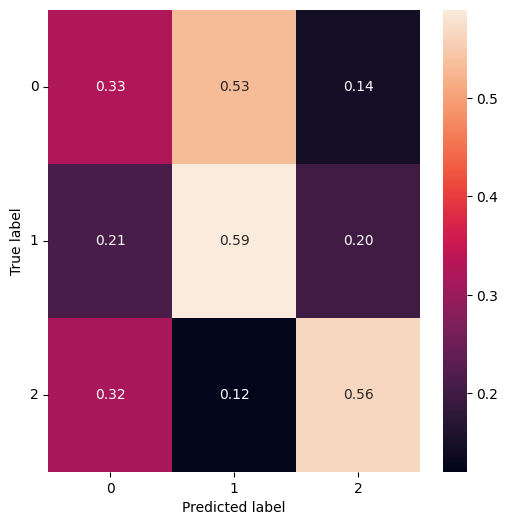

In [38]:
#Twitter Test Set
%cd ../../'Train and Test Data'/'Twitter Test'

twitter_test = pd.read_csv('twitter_anxiety_depression_neutral.csv')
test_X = twitter_test['cleanedtweet']
test_Y = twitter_test['label']
test_dataset = list(zip(test_X, test_Y))
test_X, test_Y = vectorize_batch(test_dataset)

#Evaluate model on test set
y_pred = test(model, test_X)
y_true = test_Y.cpu().numpy()
score = f1_score(y_true, y_pred, average='micro')
print('F1 score on test = {}'.format(score))
clf_report = classification_report(y_true, y_pred)
print('Classification report on test')
print(clf_report)

#confusion matrix on validation set
print(0,"Anxiety", 1,"Depression", 2,"Neutral")
cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.ylabel('True label')
plt.yticks(rotation=0)
plt.xlabel('Predicted label')
plt.show()

In [ ]:
import time
time.sleep(5)

from google.colab import runtime
runtime.unassign()